# Figure: Experimental setup and inference procedure

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import scipy.optimize as optimize
import pymc3 as pm
import arviz as az
import theano.tensor as tt

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import seaborn as sns; sns.set_theme(style='ticks', context='paper');

%reload_ext watermark
%watermark -a "Mathieu Baltussen" -d -t -u -v -iv

Author: Mathieu Baltussen

Last updated: 2022-01-07 14:22:51

Python implementation: CPython
Python version       : 3.9.5
IPython version      : 7.28.0

seaborn   : 0.11.1
pandas    : 1.2.4
arviz     : 0.11.4
scipy     : 1.6.2
pymc3     : 3.11.4
sys       : 3.9.5 | packaged by conda-forge | (default, Jun 19 2021, 00:32:32) 
[GCC 9.3.0]
matplotlib: 3.4.2
numpy     : 1.20.3
theano    : 1.1.2



## Helper functions for plotting

In [2]:
XSIZE = 7 #inch
YSIZE = XSIZE/np.sqrt(2) #inch

def savefig(name):
    """Helper function to save figures in desired formats"""
    plt.savefig(f"../figures/{name}.svg")
    plt.savefig(f"../figures/{name}.png", dpi=300)

def generate_figure(n_col, n_row):
    """ Helper function to generate gridspec figures"""
    DX = XSIZE/n_col
    DY = YSIZE/n_col
    YLENGTH = n_row*DY

    fig = plt.figure(figsize=(XSIZE, YLENGTH), constrained_layout=True)
    gs = fig.add_gridspec(n_row, n_col)
    return fig, gs

def plot_reactor(ax, input_substrates, output_substrates, enzymes, r_enzymes=0.1):
    """ Helper function to plot reactor schematics with inputs, outputs, an encapsulated enzymes"""
    WIDTH = 0.55
    HEIGHT = 0.45
    reactor = mpatches.FancyBboxPatch(
        ((1 - WIDTH) / 2, (1 - HEIGHT) / 2),
        width=WIDTH,
        height=HEIGHT,
        fill=False,
        edgecolor="black",
        linewidth=3,
        boxstyle=mpatches.BoxStyle("Round", pad=0.0, rounding_size=0.15),
    )
    reactor.set_clip_on(False)
    ax.add_patch(reactor)

    for i, substrate in enumerate(input_substrates):
        ax.annotate(
            text=substrate,
            xy=((1 - WIDTH) / 2, 0.5 - (len(input_substrates)-1) * 0.1/2 + i * 0.1),
            xytext=(0.1, 0.5 - (len(input_substrates)-1) * 0.1/2 + i * 0.1),
            arrowprops={"lw": 2, "arrowstyle": "-", "color": "black"},
            verticalalignment="center",
            horizontalalignment='right',
            fontsize=12,
            fontweight="medium",
        )
    for i, substrate in enumerate(output_substrates):
        ax.annotate(
            text=substrate,
            xy=((1 + WIDTH) / 2, 0.5 - (len(output_substrates)-1) * 0.1/2 + i * 0.1),
            xytext=((1 + WIDTH) / 2 + 0.15, 0.5 - (len(output_substrates)-1) * 0.1/2 + i * 0.1),
            arrowprops={
                        "arrowstyle": "<-",'connectionstyle':"arc3",
                        "lw": 2,  "color": "black",
            },
            verticalalignment="center",
            horizontalalignment='left',
            fontsize=12,
            fontweight="medium",
        )
    enzyme_colors = {'HK': "C0", 'GDH': "C1", "G6PDH": "C2", 'Tr': 'C3' }
    indices = np.arange(0, len(enzymes), dtype=float) + 0.5
    r = np.sqrt(indices/len(enzymes))
    theta = np.pi * (1 + 5**0.5) * indices
    if len(enzymes) == 1:
        x_coords = np.array([0.5])
        y_coords = np.array([0.5])
    else:
        x_coords = r*np.cos(theta)*WIDTH/2.9 + 0.5
        y_coords = r*np.sin(theta)*HEIGHT/2.9 + 0.5

    for i, enzyme in enumerate(enzymes):
        with sns.color_palette("Pastel1"):
            if len(enzyme) > 3:
                FS = (12-len(enzyme))
            else: 
                FS = 12
            enzyme_patch = mpatches.Circle((x_coords[i], y_coords[i]), radius=r_enzymes, edgecolor="black",linewidth=1, fc=enzyme_colors[enzyme])
            enzyme_patch.set_clip_on(False)
            enzyme_label = ax.annotate(enzyme, xy=(x_coords[i], y_coords[i]), va='center_baseline', ha='center', fontsize=FS, fontweight="medium")
            ax.add_patch(enzyme_patch)
    return ax


## Data loading

In [4]:
""" Time-series data (selected subset)"""

CEKS33_timedata = pd.read_csv("../data/CEKS33_time.csv")
period_1 = CEKS33_timedata.time.between(2500, 24300)
CEKS33_timedata = CEKS33_timedata[period_1]
CEKS33_timedata = CEKS33_timedata.assign(time = CEKS33_timedata/60)

""" Steady-state data (selected subset, no inhibitor)"""
data = pd.read_csv("../data/CEKS33.csv")
kf = 0.125  # minute^-1
E = 0.012
data = data.assign(kf=kf, Tr=E)
data = data[data.AAA == 0]

## Probabilistic model (PyMC3)

In [5]:
with pm.Model() as model:
    k_cat = pm.Uniform("k_cat", 0, 500)
    K_M = pm.Uniform("K_M", 0, 500)
    sigma = pm.Exponential("sigma", 10)

    S_in = data["R"].values
    P_obs = data["AMC"].values
    S_obs = S_in - P_obs # Substrate concentration inside reactor determined via stoichiometric conservation at steady-state
    E = data["Tr"].values
    kf = data["kf"].values

    # Inference of probabilistic model at steady-state conditions
    P = pm.Normal(
        "obs", mu=k_cat * E * S_obs / (kf * (K_M + S_obs)), sigma=sigma, observed=P_obs
    )
    idata = pm.sample(
        1000,
        tune=1000,
        cores=4,
        step=pm.NUTS(target_accept=0.95),
        return_inferencedata=True,
    )


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, K_M, k_cat]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.
The number of effective samples is smaller than 25% for some parameters.


## Statistical model (SciPy)

In [6]:
kf = 0.125  # minute^-1
E = 0.012
S_in_range = np.linspace(0, 600, 100)

def steady_state_model(S_in, k_cat,K_M):
    V_M = k_cat * E
    Vk = V_M/kf
    # Explicit equation form of steady-state product-concentration is used.
    return 0.5*(Vk + K_M + S_in) - 0.5*np.sqrt((Vk + K_M + S_in)**2 - 4*Vk*S_in)

popt, pcov = optimize.curve_fit(steady_state_model, data["R"], data["AMC"])
perr = np.sqrt(np.diag(pcov))
residuals = data["AMC"] - steady_state_model(data["R"], *popt)
ss_residuals = np.sum(residuals**2)
ss_total = np.sum((data["AMC"] - np.mean(data["AMC"]))**2)
r_squared = 1 - (ss_residuals/ss_total)
print("=== Least-squares kinetic parameter values ===")
print(f"k_cat = {popt[0]:.1f} +- {perr[0]:.1f}")
print(f"K_M = {popt[1]:.1f} +- {perr[1]:.1f}")
print(f"R^2 = {r_squared:.5f}")

=== Least-squares kinetic parameter values ===
k_cat = 102.6 +- 4.3
K_M = 121.7 +- 14.4
R^2 = 0.99236


## Sampling of the posterior predictive distribution

In [7]:
with model:
    post_pred = pm.sample_posterior_predictive(idata, var_names=['obs', 'k_cat', 'K_M', 'sigma'])
posterior_df = pd.DataFrame({'k_cat': post_pred['k_cat'], 'K_M': post_pred['K_M'], 'sigma': post_pred['sigma']})

post_pred_obs = steady_state_model(S_in_range[:,None], post_pred['k_cat'], post_pred['K_M'])
post_pred_qs = np.quantile(post_pred_obs, [0.025, 0.25, 0.5, 0.75, 0.975], axis=1)


## Creation of the figure

k_cat = 102.6 +- 4.3
K_M = 121.7 +- 14.4
R^2 = 0.99236


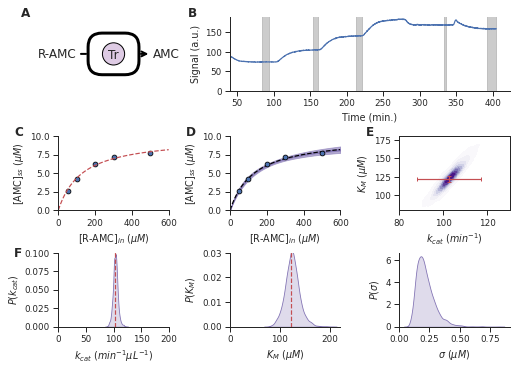

In [8]:
fig, gs = generate_figure(3,3)
ax_1 = fig.add_subplot(gs[0,0])
ax_2 = fig.add_subplot(gs[0,1:])
ax_3 = fig.add_subplot(gs[1,0])
ax_4 = fig.add_subplot(gs[1,1])

ax_1.axis("off")
ax_1.set_ylim(0.1,0.9)
ax_1.set_aspect("equal")
ax_1.text(-0.5, 1.0, 'A', transform=ax_1.transAxes, weight="bold", size=12)
plot_reactor(ax_1, ['R-AMC'], ['AMC'], ['Tr'], r_enzymes=0.12)

ax_2.text(-0.15, 1.0, 'B', transform=ax_2.transAxes, weight="bold", size=12)
ax_2.plot(CEKS33_timedata.time, CEKS33_timedata.signal)
ax_2.set_xlabel("Time (min.)")
ax_2.set_ylabel("Signal (a.u.)")
ax_2.set_xlim(40)
ax_2.set_ylim(0)
ax_2.fill_betweenx([0,200], 5000/60, 5600/60, alpha=0.2, color='black')
ax_2.fill_betweenx([0,200], 9200/60, 9600/60, alpha=0.2, color='black')
ax_2.fill_betweenx([0,200], 12730/60, 13240/60, alpha=0.2, color='black')
ax_2.fill_betweenx([0,200], 23560/60, 24300/60, alpha=0.2, color='black')
ax_2.fill_betweenx([0,200], 20000/60, 20200/60, alpha=0.2, color='black')
sns.despine(ax=ax_2)

ax_3.text(-0.4, 1.0, 'C', transform=ax_3.transAxes, weight="bold", size=12)
ax_3.scatter(data.R, data.AMC, ec='black')
ax_3.plot(S_in_range, steady_state_model(S_in_range, *popt), "--", color="C3")
ax_3.set_xlim(0, 600)
ax_3.set_ylim(0, 10)
ax_3.set_xlabel(r"$[$R-AMC$]_{in}~(\mu M)$")
ax_3.set_ylabel(r"$[$AMC$]_{ss}~(\mu M)$")
sns.despine(ax=ax_3)

ax_4.text(-0.4, 1.0, 'D', transform=ax_4.transAxes, weight="bold", size=12)
ax_4.scatter(data.R, data.AMC, ec='black',zorder=10)

ax_4.fill_between(S_in_range, post_pred_qs[0], post_pred_qs[4], color="C4", alpha=0.6)
ax_4.fill_between(S_in_range, post_pred_qs[1], post_pred_qs[3], color="C4", alpha=0.8)
ax_4.plot(S_in_range, post_pred_qs[2], "--", color="black", )

ax_4.set_xlim(0, 600)
ax_4.set_ylim(0, 10)
ax_4.set_xlabel(r"$[$R-AMC$]_{in}~(\mu M)$")
ax_4.set_ylabel(r"$[$AMC$]_{ss}~(\mu M)$")
sns.despine(ax=ax_4)

ax_5 = fig.add_subplot(gs[1,2])
sns.kdeplot(data=posterior_df, 
            x='k_cat', y='K_M', fill=True, cmap="Purples"
                )
ax_5.set_ylim(80, 180)
ax_5.set_xlim(80, 130)
ax_5.set_ylabel(r"$K_{M}~(\mu M)$")
ax_5.set_xlabel(r"$k_{cat}~(min^{-1})$")
ax_5.text(-0.3, 1.0, 'E', transform=ax_5.transAxes, weight="bold", size=12)


print(f"k_cat = {popt[0]:.1f} +- {perr[0]:.1f}")
print(f"K_M = {popt[1]:.1f} +- {perr[1]:.1f}")
print(f"R^2 = {r_squared:.5f}")

ax_5.errorbar(popt[0], popt[1], perr[0], perr[1], color='C3', capsize=2.0, ms=200, mfc='C3', mec='C3')

ax_6 = fig.add_subplot(gs[2,0])
ax_7 = fig.add_subplot(gs[2,1])
ax_8 = fig.add_subplot(gs[2,2])

sns.kdeplot(posterior_df["k_cat"], ax=ax_6, fill=True, color='C4')
ax_6.vlines(popt[0], 0, 1, linestyles="--", colors='C3')

sns.despine(ax=ax_6)
ax_6.set_xlim(0, 200)
ax_6.set_ylim(0, 0.10)
ax_6.set_ylabel(r"$P(k_{cat})$")
ax_6.set_xlabel(r"$k_{cat}~(min^{-1}\mu L^{-1})$")

sns.kdeplot(posterior_df["K_M"], ax=ax_7, fill=True, color='C4')
sns.despine(ax=ax_7)
ax_7.vlines(popt[1], 0, 1, linestyles="--", colors='C3')
ax_7.set_ylim(0, 0.03)
ax_7.set_xlim(0)
ax_7.set_ylabel(r"$P(K_{M})$")
ax_7.set_xlabel(r"$K_{M}~(\mu M)$")

sns.kdeplot(posterior_df["sigma"], ax=ax_8, fill=True, color='C4')
sns.despine(ax=ax_8)
ax_8.set_xlim(0)
ax_8.set_ylabel(r"$P(\sigma)$")
ax_8.set_xlabel(r"$\sigma~(\mu M)$")

ax_6.text(-0.4, 0.95, 'F', transform=ax_6.transAxes, weight="bold", size=12)

savefig("fig_setup")

plt.show()